<b>Forecasting experimentation 2 - Flight passenger data</b>

In [1]:
# usual imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = sns.load_dataset('flights')

In [3]:
df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


<b>Before going further, we'll scale the passengers-value to be between 0 and 1</b>

In [4]:
scaler = MinMaxScaler()
df[['passengers']] = scaler.fit_transform(df[['passengers']])
df.index = df.index * 0.1 + 1

In [5]:
df

,year,month,passengers
1.0,1949,Jan,0.015444
1.1,1949,Feb,0.027027
1.2,1949,Mar,0.054054
1.3,1949,Apr,0.048263
1.4,1949,May,0.032819
...,...,...,...
14.9,1960,Aug,0.969112
15.0,1960,Sep,0.779923
15.1,1960,Oct,0.689189
15.2,1960,Nov,0.552124


<b>X_train, y_train, X_test, y_test</b>

In [6]:
# let's figure out a proper cutoff point
# for train/test split
cutoff = int(len(df) * 0.70)

# train data
X_train = df.index[0:cutoff]
y_train = df['passengers'].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df['passengers'].iloc[cutoff:]


# convert to NumPy -array -format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

# NOTE to self: is this necessary?
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

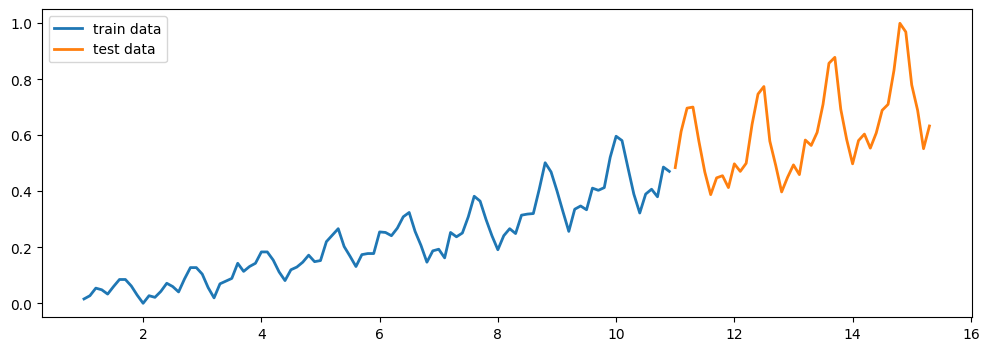

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(X_train, y_train, lw=2, label='train data')
ax.plot(X_test, y_test,  lw=2, label='test data')
ax.legend(loc="upper left")
plt.show()

In [8]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# this is the time step size
# so if we have 1000 points, and look_back is 20 => 50 time steps
look_back  = 10

# using 1 => using time steps
# anything over 1 => using windowing
window_size = 1

# the amount of data fed to the neural network
# while training. the bigger it is, faster the training
# but with forecasts it also affects the performance
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      # sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      # sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [9]:
from keras.models import Sequential
from keras.layers import Dense

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# depends on the situation which one suits your dataset better
from keras.layers import LSTM
from keras.layers import SimpleRNN

# make a simple LSTM -network
# you can adjust the number of neurons
# you can also try SimpleRNN
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# start training the data, use also validation data for metrics later
model.fit(train_generator, epochs=50, verbose=1, validation_data=test_generator)



Epoch 1/50

90/90 [==============================] - 4s 16ms/step - loss: 0.0241 - val_loss: 0.0491
Epoch 2/50
90/90 [==============================] - 1s 11ms/step - loss: 0.0077 - val_loss: 0.0387
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 0.0062 - val_loss: 0.0305
Epoch 4/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0051 - val_loss: 0.0268
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 0.0054 - val_loss: 0.0235
Epoch 6/50
90/90 [==============================] - 1s 16ms/step - loss: 0.0050 - val_loss: 0.0270
Epoch 7/50
90/90 [==============================] - 1s 16ms/step - loss: 0.0050 - val_loss: 0.0232
Epoch 8/50
90/90 [==============================] - 1s 12ms/step - loss: 0.0048 - val_loss: 0.0219
Epoch 9/50
90/90 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.0216
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 0.0047 - val_loss: 0.0226
Epoch 

<Axes: >

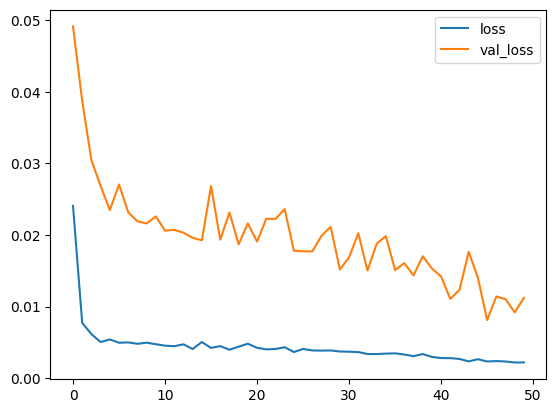

In [10]:
# training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [11]:
test_predictions  = model.predict(test_generator)

34/34 [==============================] - 1s 3ms/step


In [12]:
X_test[-1]

15.3

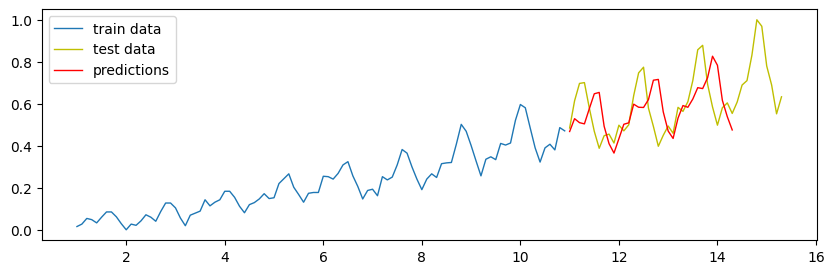

In [13]:
# this code is not optimal
# our code should instead scale based on the X_train / X_test
x = np.arange(11.0, 14.4, 0.1)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the training data to inspect the
# the predictions vs. test data separately
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test, y_test, lw=1, c='y', label='test data')
ax.plot(x, test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()

# it smees the trend is now closer but is in wrong phase (offset)